<div style="text-align: right"> Brian Wiley <br/>
EN.705.601.3VL.SP20 Applied Machine Learning </div>

## Assignment 6
### Applied Machine Learning

For this lab we are reviewing the Suicides dataset from the third assignment.  Taking where we left off in class I will test both a weak GaussianNB vs. RandomForestClassifier.  Knowing from assignment 3 that I will be OneHotEncoding the countries, I am going to assume that there will be an increase using an ensemble of the top features.  The question for this dataset is how much.  We will see something interesting as well because the highest ranked feature is extremely correlated with to target variable after slicing that prior to ensemble dropping the lowest correlated features doesn't really change the NB classifier.  It is only after creating the ensemble it increases and only when the ensemble includes this higest ranked column.  Not as good as a dataset and the pre-processed breast cancer for try this NB ensemble as we will see that RandomForest wins out.

__1. [20 pts] What is the dependent variable you decided? Why?__

As stated in assignment 3 "The dependent variable should be `suicides/100k pop` so that we can, predict given an example, whether that example will produce a numerical rate equivalent those that fit the examples features. We want to use this column rather than the column suicides_no because the rate is more relative to how large the population could be"$^{[1]}$ (Wiley, 2020).

__2. [20 pts] Set the dependent variable into two categories based on a defensible criteria. (Hint:
skirts of the probability density function)__

We could also split by quantiles using pandas.qcut and set the quantiles to any percentage we want.  Therefore I am going to use a 75% split where the lower 75% of the column `suicides/100k pop` will be in the low category (value of 0) for suicides and the higher 25% will be in high category (value of 1)

In [1]:
## Import dataset and pre-process from assignment 3
import pandas as pd
import numpy as np
import seaborn as sns;
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/master.csv')

df = df.drop(['HDI for year', 'country-year'], axis=1)
df.rename(columns={' gdp_for_year ($) ': 'gdp_for_year ($)'}, inplace=True)
df['gdp_for_year ($)'] = df['gdp_for_year ($)'].str.replace(",", "").astype(float)

df['age_group float'] = df['age'].map({'5-14 years': 0, 
                                       '15-24 years': 1, 
                                       '25-34 years': 2, 
                                       '35-54 years': 3, 
                                       '55-74 years': 4, 
                                       '75+ years': 5})

df['generation float'] = df['generation'].map({'Generation Z': 0, 
                                       'Millenials': 1, 
                                       'Generation X': 2, 
                                       'Boomers': 3, 
                                       'Silent': 4, 
                                       'G.I. Generation': 5})

df.drop(['age', 'generation'], axis=1, inplace=True)

## copy dataframe  so we can cut into low and high for `suicides/100k pop`
df2 = df.copy(deep=True)

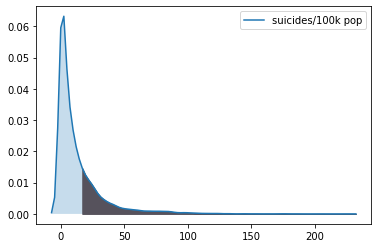

In [2]:
## before cutting the target column lets visualize the 75% quantile in the density plot
_75 = df2['suicides/100k pop'].quantile(q=0.75)
ax = sns.kdeplot(df2['suicides/100k pop'], shade=True)
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, where=(kde_x > _75), interpolate=True, 
                color="#56525c")

Now we can cut the target column into low and high and set our X and y for the classifiers and OneHotEncode categorical variables.

In [3]:
## cut and label
df2['suicide_split'] = pd.qcut(df2['suicides/100k pop'], q=[0, .75, 1.], labels=[0,1])

In [4]:
## what are the quantiles split at?
df2['suicides/100k pop'].quantile(0.75)

16.62

In [5]:
## drop old column
df2.drop('suicides/100k pop', axis=1, inplace=True)

In [6]:
## set y to target
y =  df2.loc[:, df2.columns == 'suicide_split'].values.ravel()

## OneHotEncode categorical columns
df_ohe = pd.get_dummies(df2, columns=['sex', 'country'], drop_first=True)
df_ohe.drop('suicide_split', axis=1, inplace=True)

## get X features set
X = df_ohe.values
print(X.shape)

## this will confirm our pearson correlation columns
df_ohe.columns

(27820, 108)


Index(['year', 'suicides_no', 'population', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'age_group float', 'generation float', 'sex_male',
       'country_Antigua and Barbuda', 'country_Argentina',
       ...
       'country_Thailand', 'country_Trinidad and Tobago', 'country_Turkey',
       'country_Turkmenistan', 'country_Ukraine',
       'country_United Arab Emirates', 'country_United Kingdom',
       'country_United States', 'country_Uruguay', 'country_Uzbekistan'],
      dtype='object', length=108)

__3. [20 pts] Develop your classification model(s) to solve your defined problem__

I am going to do the GaussianNB and perform basically the same weak and ensemble NB from class.  Then afterwards I am going to try 2 other ensemble classifiers, RandomForest and GradientBoosting along with LinearSVC.  Then we can include a VotingClassifier at the end for the ensemble classifiers.  Lastly for number #5 we will use the VotingClassifier for the classification and for #6 we will use the regressor versions RandomForestRegressor, GradientBoostingRegressor, and LinearSVR respective to get a probability.

__4. [20 pts] Evaluate (and report) the model performance(s) using some of the standard
techniques (e.g. 80-20 split, 10-fold cross validation, etc.).__

In [7]:
## get priors and also make X an np.ndarray
unique, counts = np.unique(y, return_counts=True)
priors = counts/len(y)
priors

array([0.75003595, 0.24996405])

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def eval_classifier(clf, _X, y, k, random_state=0):
    ''' 
    Evaluates k-fold for classifier
    
    Parameters
    ------------
    clf : sklearn classifer
    
    X : array-like, shape (n_samples, n_features)
      Feature set.
    y : array-like, shape (n_samples,)
      Target values.
    k : int
      Number of k-folds

    Returns
    -----------
    acc : 1d-array
      Accuracy array for k-fold CV 
    '''
    
    kfold = StratifiedKFold(n_splits=k, random_state=random_state, shuffle=True)
    acc = cross_validate(clf, _X, y, cv=kfold, scoring='accuracy')
    
    return acc['test_score']

In [9]:
acc = eval_classifier(GaussianNB(priors=priors), X, y, k=5)
print(f'GaussianNB CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

GaussianNB CV accuracy=0.75 ±0.002


Now lets try the ensemble from class.

In [10]:
def weakNB_fit(cols, X, y):
    ''' 
    fits GaussianNB with subset of columns
    
    Parameters
    ------------
    cols : int array-like (feature columns)
      Array of selected columns by column number
    X : array-like, shape (n_samples, n_features)
      Feature set.
    y : array-like, shape (n_samples,)
      Target values.

    Returns
    -----------
    classifier : object
      Fit of GaussianNB with X, y
    '''
    
    X_cols = X[:, cols]
    unique, counts = np.unique(y, return_counts=True)
    priors = counts/len(y) 
    
    return GaussianNB(priors=priors).fit(X_cols, y)


def weakNB_predict(clf, cols, X):
    X_cols = X[:, cols]
    
    return clf.predict(X_cols), clf.predict_proba(X_cols)


def features_random(M, m, num_ensembles=1):
    from numpy.random import choice
    
    return [choice(M, m, replace=False) for _ in range(num_ensembles)]
  
    
def eval_weak(X, y, num_ensembles, num_features, k, random_state=0):
    """
    Doesn't use weakNB_fit or weakNB_predict from class
    
    So we need priors
    """
    acc = []  
    counts = np.unique(y, return_counts=True)[1]
    priors = counts/len(y) 
    cols = features_random(X.shape[1], num_features, num_ensembles)
    kfold = StratifiedKFold(n_splits=k, random_state=random_state, shuffle=True)
    for i in range(num_ensembles):
        acc += [cross_validate(GaussianNB(priors=priors),
                              X[:, cols[i]], y, 
                              cv=kfold, scoring='accuracy')['test_score']]
        
    return acc


def ensembleNB_fit(cols, X, y):
    ''' 
    fits GaussianNB with subset of columns
    
    Parameters
    ------------
    cols : array-like, shape (n_ensembles, n_features)
      list of ensemble columns
    X : array-like, shape (n_samples, n_features)
      Feature set.
    y : array-like, shape (n_samples,)
      Target values.

    Returns
    -----------
    classifiers : 1-dimensional object array, shape (n_ensembles,)
      Fit of GaussianNB with X, y
    '''
    n_ensembles = len(cols)
    ensemble_clfs = []
    for i in range(n_ensembles):
        ensemble_clfs += [weakNB_fit(cols[i], X, y)]
    
    return ensemble_clfs


def ensembleNB_predict(ensemble_clfs, cols, X_test):
    n_ensembles = len(ensemble_clfs)
    assert n_ensembles == len(cols)
    y_pred_e = np.empty(shape=(n_ensembles, len(X_test)), dtype=int)
    for j in range(n_ensembles):
        predictions = weakNB_predict(ensemble_clfs[j], cols[j], X_test)
        y_pred_e[j] = predictions[0]
    
    ## this is covenient function for returning argmax without lambdas
    y_pred = np.amax(y_pred_e, axis=0)
    
    return y_pred
 
   
def eval_ensemble(X, y, n_iter, n_ensembles, n_features, k, random_state=0):
    acc = []  
    ## this array col_lists is just to see which ensembles are using the highest ranked
    cols_lists = []
    cols = features_random(X.shape[1], n_features, n_ensembles)
    cols_lists += cols
    
    for i in range(n_iter):
        kfold = StratifiedKFold(n_splits=k, random_state=random_state, shuffle=True)
        for train_ind, test_ind in kfold.split(X, y):
            clf = ensembleNB_fit(cols, X[train_ind], y[train_ind])
            y_pred = ensembleNB_predict(clf, cols, X[test_ind])
            acc += [accuracy_score(y[test_ind], y_pred)]
            
    return acc, cols_lists

First I am going to do the ensemble with all features as in class and see what features have the highest rank only because I know it will need it since top 4 are very correlated.

In [11]:
from scipy.stats import pearsonr

# Direct correlation between each column of X and the target y
corrs = np.array([pearsonr(X[:,j], y)[0] for j in range(X.shape[1])])
# Reverse sort, numpy array negation reverses the order
ranks = np.argsort(-np.absolute(corrs))

rankings = [(f'{corrs[j]:.4f}', df_ohe.columns[j]) for j in ranks]
display(rankings[:9])
display(rankings[-5:])
ranks

[('0.4255', 'sex_male'),
 ('0.3108', 'age_group float'),
 ('0.2911', 'generation float'),
 ('0.2708', 'suicides_no'),
 ('0.0761', 'country_Lithuania'),
 ('0.0700', 'country_Hungary'),
 ('0.0696', 'country_Russian Federation'),
 ('0.0687', 'country_Japan'),
 ('-0.0654', 'country_Guatemala')]

[('-0.0076', 'country_Montenegro'),
 ('0.0072', 'country_Puerto Rico'),
 ('0.0058', 'country_Singapore'),
 ('-0.0040', 'country_Macau'),
 ('0.0000', 'country_Cabo Verde')]

array([  7,   5,   6,   1,  59,  47,  82,  53,  45,  35,  13,  43,  65,
        74,  56,  54,  58,   8,  91,  27, 102,   4,  37,  15,  10,   3,
        19,  94,  39,  92,  16,  95,  98,  18,  80,  44,  46,  41,  52,
        22,  29,  14,  63,  73,  75,  31,  79,  17,  40,   0, 105,  69,
        97, 104,  32,  60,  87,  12,  62,  25,  71,  76,  23,  28,  51,
        30,  85, 100,  38, 106, 107,  20,  50, 103,  48,  93,  99,  70,
        96,  84,  57,  88,  83,  42,  55,  72,  49,  64,   9,  11,  77,
        33,  81,  36,  26,  34, 101,  86,   2,  68,  66,  90,  21,  67,
        78,  89,  61,  24], dtype=int64)

In [12]:
n_ensembles = 50
acc, cols_lists = eval_ensemble(X, y, n_iter=10, n_ensembles=n_ensembles, n_features=11, k=5, random_state=None)
print(f'Ensemble learners average Acc = {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')
print('Percentage of ensembles containing the highest rank is',
      sum([ranks[0] in arr for arr in cols_lists])/n_ensembles)

Ensemble learners average Acc = 0.25 ±0.000
Percentage of ensembles containing the highest rank is 0.06


So we see that only 10% had the feature `sex_male` and without we have nothing really.  Let's trim the top features.

In [13]:
delcols = [(i, f'{corrs[i]: .4f}', df_ohe.columns[i]) for i in ranks if np.absolute(corrs[i]) <=.051]
delete = [d[0] for d in delcols]

In [14]:
X_drop = np.delete(np.array(X, copy=True), delete, axis=1)
X_drop.shape

(27820, 35)

In [15]:
## weak NB
acc = eval_classifier(GaussianNB(priors=priors), X_drop, y, k=5, random_state=1)
print(f'GaussianNB CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

## ensemble NB
n_ensembles = 50
acc, cols_lists = eval_ensemble(X_drop, y, n_iter=5, n_ensembles=n_ensembles, n_features=10, k=5, random_state=0)
print(f'Ensemble learners average Acc = {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')
print('Percentage of ensembles containing the highest rank is',
      sum([ranks[0] in arr for arr in cols_lists])/n_ensembles)

GaussianNB CV accuracy=0.75 ±0.003
Ensemble learners average Acc = 0.25 ±0.000
Percentage of ensembles containing the highest rank is 0.3


So the ensemble NB still does bad because not many have the highest correlated feature, `sex_male` for whether male or female. So we need more features in our ensemble as looking at the below we can see that the correlation is high for whether female or male.

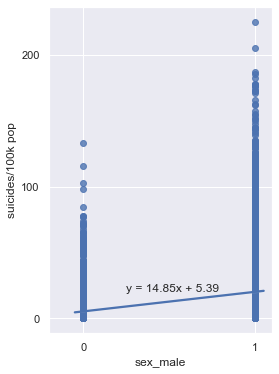

In [16]:
sns.set(color_codes=True)
df3 = pd.get_dummies(df, columns=['sex'], drop_first=True)

fig, axs = plt.subplots(figsize=(4,6), nrows=1, ncols=1)
lm = sns.regplot(x='sex_male', y='suicides/100k pop', data=df3, truncate=False, ax=axs)
lm.set(xlim=(-.2,1.1), xticks=[0, 1], yticks=[0, 100, 200])

from sklearn import linear_model
regr = linear_model.LinearRegression()
X_lm = df_ohe['sex_male'].values.reshape(-1,1)
y_lm = df['suicides/100k pop'].values.reshape(-1,1)
regr.fit(X_lm, y_lm)
slope = round(regr.coef_[0][0], 2)
y_int = round(regr.intercept_[0], 2)
textstr = f'y = {slope}x + {y_int}'
axs.text(.25, 20, textstr)

plt.show()

In [17]:
## ensemble NB
n_ensembles = 50
acc, cols_lists = eval_ensemble(X_drop, y, n_iter=5, n_ensembles=n_ensembles, n_features=20, k=5, random_state=0)
print(f'Ensemble learners average Acc = {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')
print('Percentage of ensembles containing the highest rank is',
      sum([ranks[0] in arr for arr in cols_lists])/n_ensembles)

Ensemble learners average Acc = 0.26 ±0.002
Percentage of ensembles containing the highest rank is 0.56


That did better.  But also I think we need to check really how many ensembles have the top 2 or 3 features.  Without those we are lost.

In [18]:
print('Percentage of ensembles containing the 3 highest ranks is',
      sum([all(x in list_ for x in [ranks[0], ranks[1], ranks[2]]) for list_ in cols_lists])/n_ensembles)

Percentage of ensembles containing the 3 highest ranks is 0.2


In [19]:
n_ensembles = 50
acc, cols_lists = eval_ensemble(X_drop, y, n_iter=5, n_ensembles=n_ensembles, n_features=30, k=5, random_state=0)
print(f'Ensemble learners average Acc = {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')
print('Percentage of ensembles containing the 3 highest ranks is',
      sum([all(x in list_ for x in [ranks[0], ranks[1], ranks[2]]) for list_ in cols_lists])/n_ensembles)

Ensemble learners average Acc = 0.79 ±0.007
Percentage of ensembles containing the 3 highest ranks is 0.54


There we go.  We beat the weak NB classifier but barely.

In [20]:
acc = eval_classifier(RandomForestClassifier(n_estimators=200,  
                                             random_state=1, 
                                             n_jobs=4), X, y, k=10)
print(f'RandomForestClassifier CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_classifier(LinearSVC(max_iter=5000, random_state=1), X, y, k=10)
print(f'LinearSVC CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_classifier(GradientBoostingClassifier(n_estimators=200, random_state=1), X, y, k=10)
print(f'GradientBoostingClassifier CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

RandomForestClassifier CV accuracy=0.98 ±0.002


C:\Users\bjwil\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bjwil\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bjwil\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bjwil\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bjwil\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

LinearSVC CV accuracy=0.62 ±0.178
GradientBoostingClassifier CV accuracy=0.98 ±0.002


So it looks like both ensemble classifiers, RandomForest and GradientBoosting are very good.  Now we can use a VotingClassifier which is also an ensemble and see how it performs when only train on 20% of the data.

In [21]:
from sklearn.ensemble import VotingClassifier

clf1 = RandomForestClassifier(n_estimators=200, n_jobs=4, random_state=1)
clf2 = GradientBoostingClassifier(n_estimators=200, random_state=1)
clf3 = LinearSVC(max_iter=10000, random_state=1)
voting_clf = VotingClassifier(estimators=[('RF', clf1),
                                          ('GB', clf2),
                                          ('LinSVC', clf3)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1)

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(round(accuracy_score(y_pred, y_test), 3))

C:\Users\bjwil\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.966


Pretty good.  We can also use VotingRegressor for regression for #6.

__5. [20 pts] Using your classifier model, what is the predicted category of your dependent
variable for the input: "year=2000, generation=Generation X, age=20, gender=male"?__

Let's just bring out mapping down from the top so we can get the X and y ready

df['age_group float'] = df['age'].map({'5-14 years': 0, 
                                       '15-24 years': 1, 
                                       '25-34 years': 2, 
                                       '35-54 years': 3, 
                                       '55-74 years': 4, 
                                       '75+ years': 5})

df['generation float'] = df['generation'].map({'Generation Z': 0, 
                                       'Millenials': 1, 
                                       'Generation X': 2, 
                                       'Boomers': 3, 
                                       'Silent': 4, 
                                       'G.I. Generation': 5})

In [22]:
df4 = df2.drop(columns=['country', 'suicides_no', 'population', 'gdp_for_year ($)', 'gdp_per_capita ($)'])
df4_ohe = pd.get_dummies(df4, columns=['sex'], drop_first=True)
df4_ohe.head()

,year,age_group float,generation float,suicide_split,sex_male
0,1987,1,2,0,1
1,1987,3,4,0,1
2,1987,1,2,0,0
3,1987,5,5,0,1
4,1987,2,3,0,1


In [23]:
X = df4_ohe.loc[:, df4_ohe.columns != 'suicide_split'].values
y = df4_ohe.loc[:, df4_ohe.columns == 'suicide_split'].values.ravel()
print(X.shape)
X_sample = np.array([2000, 1, 2, 1])
X_sample = X_sample.reshape(1,-1)
print(X_sample.shape)

(27820, 4)
(1, 4)


In [24]:
voting_clf = VotingClassifier(estimators=[('RF', clf1),
                                          ('GB', clf2),
                                          ('LinSVC', clf3)])

voting_clf.fit(X, y)
y_pred = voting_clf.predict(X_sample)

C:\Users\bjwil\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [25]:
y_pred[0]

0

### So this puts the sample in the low risk category.  Let's see where the average is and if it should be high.

In [26]:
## what are the quantiles split at?
print('Greater than', df['suicides/100k pop'].quantile(0.75), 'should be high else low.')

Greater than 16.62 should be high else low.


In [27]:
df[(df['sex'] == 'male') & 
    (df['year'] == 2000) &
    (df['age_group float'] == 1) &
    (df['generation float'] == 2)]['suicides/100k pop'].mean()

14.712441860465113

OK so we were correct in classifying the sample as low risk category.

__6. [20 pts bonus] Using your (perhaps a different?) model, what is the actual probability of a
"Generation X 20-year-old male living in a country with 40000 gdp_per_capita"
would commit suicide?__

df['age_group float'] = df['age'].map({'5-14 years': 0, '15-24 years': 1, '25-34 years': 2, '35-54 years': 3, '55-74 years': 4, '75+ years': 5})

df['generation float'] = df['generation'].map({'Generation Z': 0, 'Millenials': 1, 'Generation X': 2, 'Boomers': 3, 'Silent': 4, 'G.I. Generation': 5})

In [28]:
df.head()

,country,year,sex,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),age_group float,generation float
0,Albania,1987,male,21,312900,6.71,2.156625e+09,796,1,2
1,Albania,1987,male,16,308000,5.19,2.156625e+09,796,3,4
2,Albania,1987,female,14,289700,4.83,2.156625e+09,796,1,2
3,Albania,1987,male,1,21800,4.59,2.156625e+09,796,5,5
4,Albania,1987,male,9,274300,3.28,2.156625e+09,796,2,3


In [29]:
## drop columns we don't need and OneHotEncode 'sex' column
df_reg = df.drop(columns=['country', 'year', 'suicides_no', 'population', 'gdp_for_year ($)'])
df_reg_ohe = pd.get_dummies(df_reg, ['sex'], drop_first=True)
df_reg_ohe.head()

,suicides/100k pop,gdp_per_capita ($),age_group float,generation float,sex_male
0,6.71,796,1,2,1
1,5.19,796,3,4,1
2,4.83,796,1,2,0
3,4.59,796,5,5,1
4,3.28,796,2,3,1


In [30]:
X_reg = df_reg_ohe.loc[:, df_reg_ohe.columns != 'suicides/100k pop'].values
y_reg = df_reg_ohe.loc[:, df_reg_ohe.columns == 'suicides/100k pop'].values.ravel()

X_sample = np.array([40000, 1, 2, 1]).reshape(1, -1)

In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import LinearSVR

clf1 = RandomForestRegressor(n_estimators=200, n_jobs=4, random_state=3)
clf2 = GradientBoostingRegressor(n_estimators=200, random_state=3)
clf3 = LinearSVR(max_iter=10000, random_state=3)
voting_clf = VotingRegressor(estimators=[('RF_Reg', clf1),
                                          ('GB_Reg', clf2),
                                          ('LinSVR', clf3)])

voting_clf.fit(X_reg, y_reg)
y_pred = voting_clf.predict(X_sample)

C:\Users\bjwil\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [32]:
print('Probability will commit suicide is ', round(y_pred[0]/100000*100,4), "%.", sep='')

Probability will commit suicide is 0.0154%.


So this was not very far off from the probability I got from assignment three which was 0.0155%.